## Infinite-Width Bayesian Neural Networks for Bayesian Optimization

In this tutorial, we present an overview of infinite-width Bayesian neural networks (I-BNNs) [1, 2] and show how to use them as surrogate models for Bayesian optimization (BO).

Consider an fully connected neural network with $L$ hidden layers, parameter weights drawn from $\mathcal{N(0, \sigma_w)}$, bias terms drawn from $\mathcal{N(0, \sigma_b)}$, and nonlinearity $\phi$. In the infinite-width limit, the output of this network is exactly equivalent to $\mathcal{GP}(\mu, K^L)$. By the central limit theorem, we find $\mu(x) = 0$, and we can also recursively define the covariance function as
$$K^0(x, x')=\sigma_b^2+\sigma_w^2\frac{x \cdot x'}{d_\text{input}}\qquad K^l(x, x')=\sigma_b^2+\sigma_w^2F_\phi(K^{l-1}(x, x'), K^{l-1}(x, x), K^{l-1}(x', x'))$$
where $F_\phi$ is a deterministic function based on the activation function $\phi$.

We will refer to this kernel as the "I-BNN kernel". Unlike many popular GP kernels, the I-BNN covariance function is not based on Euclidean distance, allowing the GP to represent nonstationary functions. This is advantageous for many settings of Bayesian optimization, since the function we want to optimize may not have similar behavior throughout the entire input space. Furthermore, I-BNNs have been shown to work particularly well for BO problems with high-dimensional inputs [3].

BoTorch has an implementation of I-BNNs with ReLU activations: `InfiniteWidthBNNKernel`.


[1] [Y. Cho, and L. Saul. Kernel Methods for Deep Learning. Advances in Neural Information Processing Systems 22, 2009.](https://papers.nips.cc/paper_files/paper/2009/hash/5751ec3e9a4feab575962e78e006250d-Abstract.html)  
[2] [J. Lee, Y. Bahri, R. Novak, S. Schoenholz, J. Pennington, and J. Dickstein. Deep Neural Networks as Gaussian Processes. International Conference on Learning Representations 2018.](https://arxiv.org/abs/1711.00165)  
[3] [Y.L. Li, T.G.J. Rudner, A.G. Wilson. A Study of Bayesian Neural Network Surrogates for Bayesian Optimization. International Conference on Learning Representations 2024.](https://arxiv.org/abs/2305.20028)

In [1]:
# Install dependencies if we are running in colab
import sys
if 'google.colab' in sys.modules:
    %pip install botorch

In [2]:
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib
import torch
from torch import nn

from gpytorch.kernels import ScaleKernel
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

from botorch import manual_seed
from botorch.acquisition import LogExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.kernels import InfiniteWidthBNNKernel
from botorch.optim.optimize import optimize_acqf
from botorch.utils.sampling import draw_sobol_samples

warnings.filterwarnings('ignore')

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
tkwargs = {"device": device, "dtype": dtype}
matplotlib.rcParams.update({"axes.grid" : True})

SMOKE_TEST = os.environ.get("SMOKE_TEST")


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.

[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


### I-BNN Function Draws

We start by visualizing the posteriors of an I-BNN. Here, we define a toy function and draw five initial function evaluations.

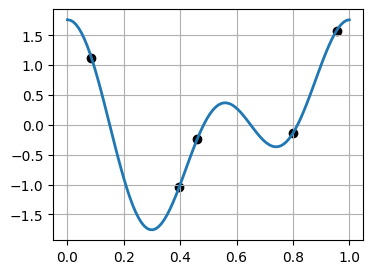

In [3]:
torch.manual_seed(1111)
def f(x):
    x = -(x - 0.15)
    return torch.sin(x * (2 * torch.pi)) + torch.sin(x * (2 * torch.pi) * 2)

x = torch.linspace(0, 1, 100).to(dtype).unsqueeze(-1)
true_y = f(x)

train_x = torch.rand(5, 1).to(**tkwargs)
train_y = f(train_x)

# visualize the function and the training data
plt.figure(figsize=(4, 3))
plt.plot(x.cpu(), true_y.cpu(), linewidth=2)
plt.scatter(train_x.cpu(), train_y.cpu(), color="black")
plt.show()

**Initializing the Model**: We now define two versions of the I-BNN, constructed using a GP with an `InfiniteWidthBNNKernel`. One version has fixed user-specified values for $\sigma^2_w$ and $\sigma^2_b$, and the other uses the marginal log likelihood to optimize these hyperparameters.

In [4]:
# Function queries are not noisy
train_Yvar = torch.full_like(train_y, 1e-8)

# I-BNN with fixed hyperparameters
ibnn_kernel = InfiniteWidthBNNKernel(depth=3, device=device)
ibnn_kernel.weight_var = 10.0
ibnn_kernel.bias_var = 5.0
model = SingleTaskGP(train_x, train_y, train_Yvar, covar_module=ibnn_kernel)
model.eval()

# I-BNN with optimized hyperparameters
model_optimize = SingleTaskGP(train_x, train_y, train_Yvar, covar_module=InfiniteWidthBNNKernel(depth=3))
mll = ExactMarginalLogLikelihood(model_optimize.likelihood, model_optimize)
fit_gpytorch_mll(mll)
model_optimize.eval()

# Default GP with Matern for comparison
model_matern = SingleTaskGP(train_x, train_y, train_Yvar)
mll_matern = ExactMarginalLogLikelihood(model_matern.likelihood, model_matern)
fit_gpytorch_mll(mll_matern)
model_matern.eval();

**Visualizating the Posterior**: 

In [5]:
def plot_posterior(ax, model, n_draws=5):
    with torch.no_grad():
        ax.plot(x.cpu(), true_y.cpu(), linewidth=2, color="black", label="True Objective", linestyle="--")
        ax.scatter(train_x.cpu(), train_y.cpu(), color="black", s=80, label="Observations")

        test_x = torch.linspace(0, 1, 100).to(**tkwargs)
        pred_f = model(test_x)

        ax.plot(test_x.cpu(), pred_f.mean.cpu(), linewidth=2, label="Mean")
        lower, upper = pred_f.confidence_region()
        ax.fill_between(test_x.cpu(), lower.cpu(), upper.cpu(), alpha=0.2, label=r'$\mu \pm 2\sigma$')

        for i in range(n_draws):
            if i == 0:
                ax.plot(test_x.cpu(), pred_f.sample().cpu(), color="green", linewidth=0.5, label="Function Draw")
            else:
                ax.plot(test_x.cpu(), pred_f.sample().cpu(), color="green", linewidth=0.5)

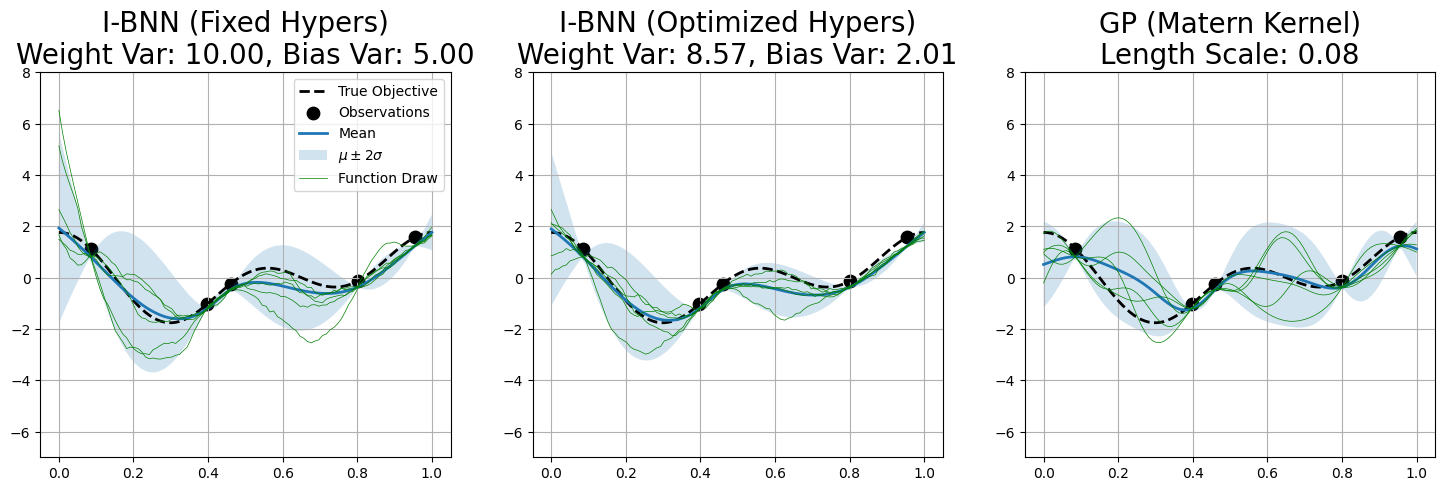

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

plot_posterior(axs[0], model)
axs[0].set_title("I-BNN (Fixed Hypers)\nWeight Var: %.2f, Bias Var: %.2f" %
                (model.covar_module.weight_var.item(), model.covar_module.bias_var.item()),
                fontsize=20)
axs[0].set_ylim(-7, 8)
axs[0].legend()

plot_posterior(axs[1], model_optimize)
axs[1].set_title("I-BNN (Optimized Hypers)\nWeight Var: %.2f, Bias Var: %.2f" %
                (model_optimize.covar_module.weight_var.item(), model_optimize.covar_module.bias_var.item()),
                fontsize=20)
axs[1].set_ylim(-7, 8)

plot_posterior(axs[2], model_matern)
axs[2].set_title("GP (Matern Kernel)\nLength Scale: %.2f" %
                model_matern.covar_module.lengthscale.item(),
                fontsize=20)
axs[2].set_ylim(-7, 8)

plt.show()

Similar to a Matern kernel, we see that the uncertainty decreases around queried points and increases as we move away. However, we find that the I-BNN function draws are more jagged compared to the Matern draws, and we also note that the uncertainty of an I-BNN towards the edges of the data increases rapidly.

### Impact of Hyperparameters

The I-BNN has three hyperparameters: the number of hidden layers, the variance of the weights, and the variance of the bias terms. Here, we visualize how modifying these hyperparameters impacts the posterior.

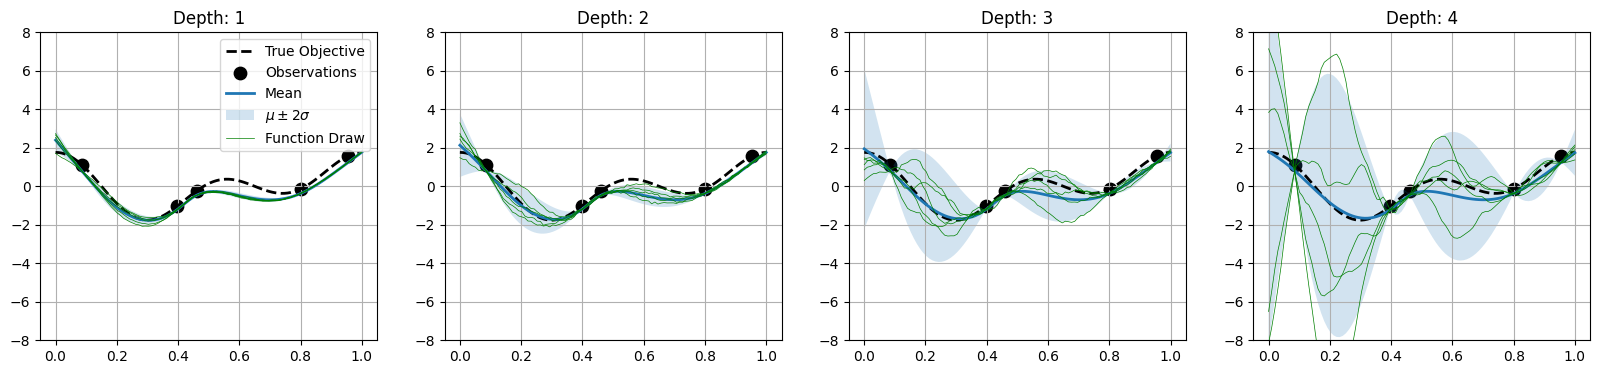

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

for i, ax in enumerate(axs):
    ibnn_kernel = InfiniteWidthBNNKernel(depth=(i+1), device=device)
    ibnn_kernel.weight_var = 10.0
    ibnn_kernel.bias_var = 2.0

    model = SingleTaskGP(train_x, train_y, train_Yvar, covar_module=ibnn_kernel).eval()
    plot_posterior(ax, model, n_draws=5)
    ax.set_title(f"Depth: {i+1}")
    ax.set_ylim(-8, 8)
    if i == 0:
        ax.legend()

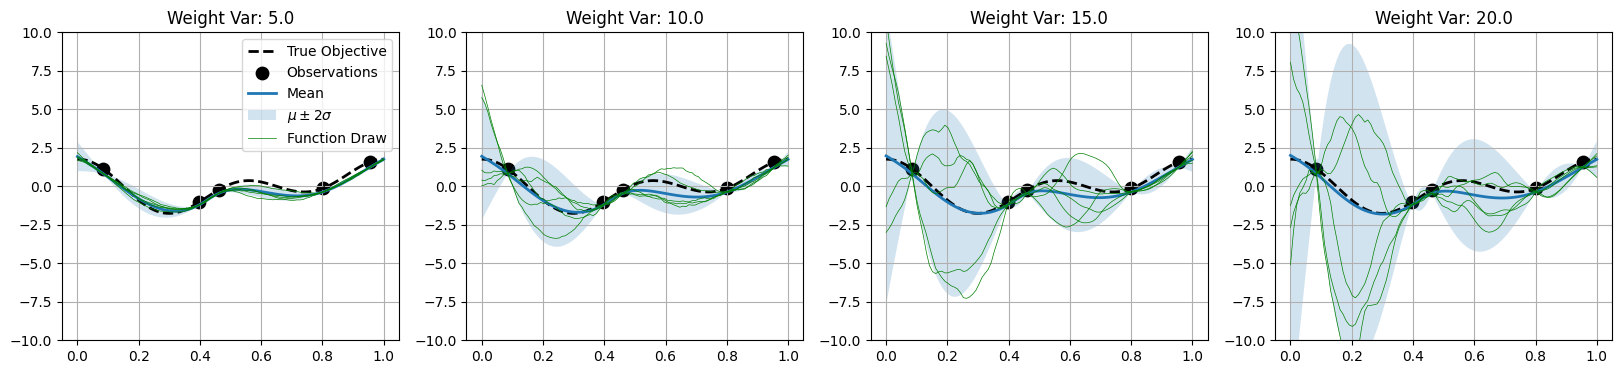

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

for i, ax in enumerate(axs):
    ibnn_kernel = InfiniteWidthBNNKernel(depth=3, device=device)
    ibnn_kernel.weight_var = (i+1) * 5
    ibnn_kernel.bias_var = 2.0

    model = SingleTaskGP(train_x, train_y, train_Yvar, covar_module=ibnn_kernel).eval()
    plot_posterior(ax, model, n_draws=5)
    ax.set_title("Weight Var: %.1f" % ((i+1) * 5))
    ax.set_ylim(-10, 10)
    if i == 0:
        ax.legend()

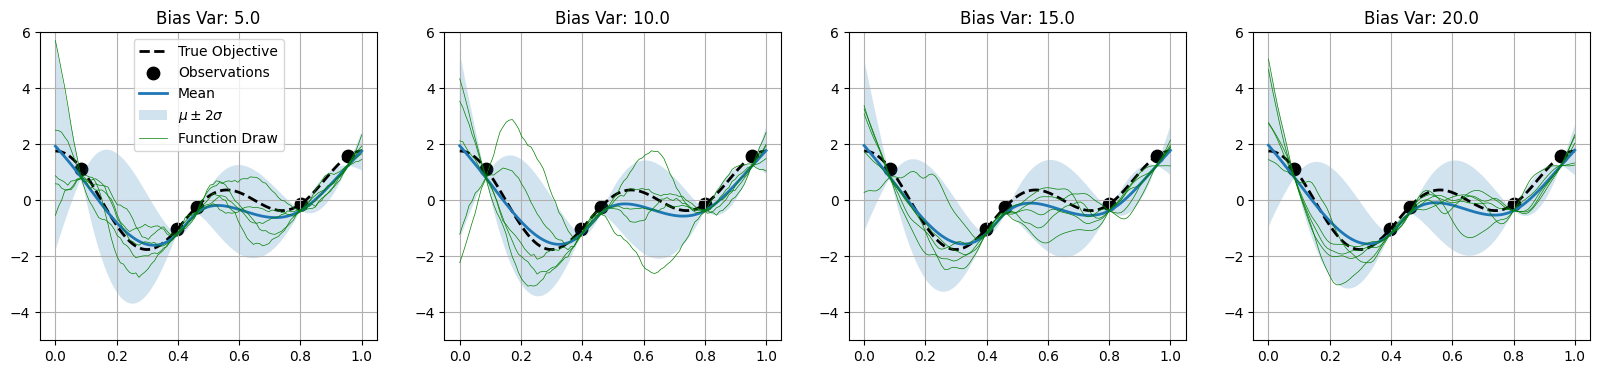

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

for i, ax in enumerate(axs):
    ibnn_kernel = InfiniteWidthBNNKernel(depth=3, device=device)
    ibnn_kernel.weight_var = 10.0
    ibnn_kernel.bias_var = (i + 1) * 5

    model = SingleTaskGP(train_x, train_y, train_Yvar, covar_module=ibnn_kernel).eval()
    plot_posterior(ax, model, n_draws=5)
    ax.set_title("Bias Var: %.1f" % ((i+1) * 5))
    ax.set_ylim(-5, 6)
    if i == 0:
        ax.legend()

### I-BNNs for Bayesian Optimization

We will now use I-BNNs as the surrogate model for a high-dimensional BO problem.

**Define High-dimensional Function and BO Setup**: We will optimize the output of a multilayer perceptron (MLP) with 2 hidden layers, 50 nodes per layer, and ReLU nonlinearities. 


In [10]:
class MLP(nn.Module):
    def __init__(self, input_dims):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dims, 50, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(50, 50, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(50, 1, dtype=torch.float64)
        )

    def forward(self, x):
        return self.layers(x)


INPUT_DIMS = 200
N_ITERATIONS = 100 if not SMOKE_TEST else 5
N_INIT = 50 if not SMOKE_TEST else 2

bounds = torch.stack([torch.zeros(INPUT_DIMS), torch.ones(INPUT_DIMS)]).to(**tkwargs)

In [11]:
ibnn_kernel = InfiniteWidthBNNKernel(2, device=device)
ibnn_kernel.weight_var = 10.0
ibnn_kernel.bias_var = 5.0
ibnn_kernel = ScaleKernel(ibnn_kernel, device=device)

# generate initial x data
init_x = draw_sobol_samples(bounds=bounds, n=N_INIT, q=1).to(**tkwargs)
init_x = init_x.squeeze(-2) # remove batch dimension

In [12]:
# generate y
with manual_seed(seed=1234):
    mlp_model = MLP(INPUT_DIMS).to(**tkwargs)
    params = torch.nn.utils.parameters_to_vector(model.parameters())
    params = torch.randn_like(params, dtype=torch.float64)
    torch.nn.utils.vector_to_parameters(params, model.parameters())
mlp_model.eval()

with torch.no_grad():
    init_y = mlp_model(init_x)

**BO loop**: We use Sobol sampling to initialize the BO problem, and we use the Expected Improvement acquisition function.

In [13]:
optimize_hypers = False

train_x = init_x.clone()
train_y = init_y.clone()

for iteration in range(N_ITERATIONS):
    # fit model to data
    model = SingleTaskGP(
        train_x, train_y, covar_module=ibnn_kernel
    )
    if optimize_hypers:
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)
    model.eval()

    # optimize acquisition function
    candidate_x, acq_value = optimize_acqf(
        acq_function=LogExpectedImprovement(model, train_y.max()),
        bounds=bounds,
        q=1,
        num_restarts=10,
        raw_samples=200,
    )
    candidate_x = candidate_x.double()

    # update training points
    train_x = torch.cat([train_x, candidate_x])
    with torch.no_grad():
        new_y = mlp_model(candidate_x)
    train_y = torch.cat([train_y, new_y])

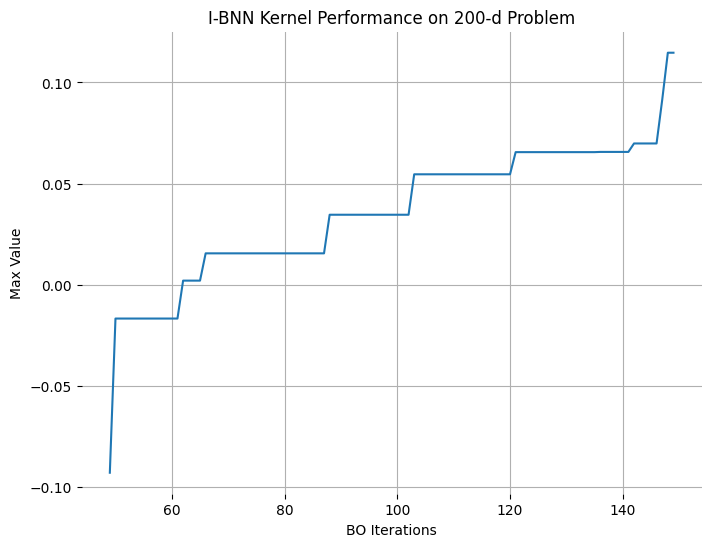

In [14]:
plt.figure(figsize=(8, 6))
plt.grid(True)

cum_max = torch.cummax(train_y.squeeze(), dim=0)[0].cpu()
plt.plot(range(N_INIT-1, len(cum_max)), cum_max[N_INIT-1:])

plt.xlabel("BO Iterations")
plt.ylabel("Max Value")
plt.title(f"I-BNN Kernel Performance on {INPUT_DIMS}-d Problem")
plt.box(False)
plt.show()